In [1]:
%matplotlib inline
from __future__ import print_function, division
from astropy.table import Table
from itertools import product
from scipy.optimize import curve_fit
from scipy.io import readsav
from scipy.interpolate import RectBivariateSpline
from astropy.cosmology import Planck15 as cosmo
from pandas import HDFStore
import pandas as pd
import sys
sys.path.insert(0, '/global/common/cori/contrib/lsst/apps/anaconda/py3-envs/DESCQA/lib/python3.6/site-packages')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import h5py
from GCR import GCRQuery
import GCR 
plt.rcParams['font.size'] = 12
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0

from IPython.display import display

sys.path.insert(0, '/global/homes/j/jderose/project/gcr-catalogs-candels/')
import GCRCatalogs

sns.set(style='ticks', palette='colorblind')
sns.despine()

In [22]:
def galaxy_size_corrections(df):
    """

        make size corrections as prescribed by rss
        want to save r_*_proj_star, r_*_proj_H, BT_light, BT_mass
        
    """

    #df = catalog.get_quantities(required_quantities)

    chi_gas     = 1.7 # converts from baryonic (stars+gas) disk to stellar disk scale radius
    fproj_disk  = 1.0 # from 3D to 2D projected radius for disk
    fproj_sph   = 2.0*0.340 # from 3D to 2D projected radius for spheroid
    rstar_to_rv = 0.76 # convert from stellar mass radius to V-band radius

    # convert 3d stellar mass radii to V-band projected radii
    # the extra 1.678 below converts from scale radius to reff
    df['r_disk_proj']  = 1.678 * fproj_disk * (df['size_disk_true'] / chi_gas) / rstar_to_rv
    df['r_bulge_proj'] = fproj_sph*df['size_bulge_true'] / rstar_to_rv
    
    #also want projected stellar mass radii in kpc
    df['r_disk_proj_star']  = 1.678 * fproj_disk * (df['size_disk_true'] / chi_gas)
    df['r_bulge_proj_star'] = fproj_sph * df['size_bulge_true']

    # van der Wel paper
    wavdepd = -0.35 + (0.12 * df['redshift_true']) - 0.25 * np.log10(df['stellar_mass'])
    wavdepb = -0.25
    zp      = np.zeros(len(df['redshift_true']))

    zp[df['redshift_true']<=1.5] = 1.5
    zp[df['redshift_true']>1.5]  = 2.2

    # convert to h-band radius
    df['r_disk_proj_H']  = df['r_disk_proj']  / (((1 + df['redshift_true']) / (1+zp)) ** wavdepd)
    df['r_bulge_proj_H'] = df['r_bulge_proj'] / (((1 + df['redshift_true']) / (1+zp)) ** wavdepb)

    # B/T using light
    dustcorrection160 = 10 ** ((df['mag_true_nodust_f160w_wfc3'] - df['mag_true_dust_f160w_wfc3']) / 2.5)
    wfc160dustbulge   = -2.5 * np.log10(dustcorrection160) + df['mag_true_nodust_bulge_f160w_wfc3']

    df['BT_light'] = 10 ** ((df['mag_true_dust_f160w_wfc3'] - wfc160dustbulge) / 2.5)
    df['BT_mass']  = df['stellar_mass_bulge'] / df['stellar_mass']
    
    return df

In [23]:
def convertBT(bt, Rbd, lookuptable):
    "get light profile parameters for galaxies in mocks"
    wuyts=readsav(lookuptable, python_dict=True)
    wuytsbt, wuytsreb = wuyts['bt_arr'], wuyts['reb_arr']
    wuytsret, wuytsn = wuyts['ret_grid'], wuyts['n_grid']
    nfunc=RectBivariateSpline(wuytsbt, wuytsreb, wuytsn)
    refunc=RectBivariateSpline(wuytsbt, wuytsreb, wuytsret)
    #print nfunc(bt, Rbd), refunc(bt, Rbd)
    return nfunc(bt, Rbd), refunc(bt, Rbd)

convertBT=np.vectorize(convertBT)

def galaxy_profiles(df, lookuptable_fname):
    """
        add profile parameters to dataframe and save to specified h5 file
        want to save:
        bulge-to-disk
        
    """
    
    # add BT ratio and BD ratio parameters

    df['BD_light'] = df['r_bulge_proj_H']/df['r_disk_proj_H'] 

    # add sersic n and effective radius
    df['n_sersic'],re = convertBT(df['BT_light'],df['BD_light'],lookuptable_fname)

    #reff in kpc
    df['reff'] = re*df['r_disk_proj_H'] 

    df['d_a'] = cosmo.angular_diameter_distance(df['redshift_true']).value*1000.0
    df['d_L'] = cosmo.luminosity_distance(df['redshift_true']).value*1000.0
    
    # add angular radius from small angle approximation
    df['angular_radius'] = df['reff']/df['d_a'] # in radians
    df['angular_radius'] *= 180/np.pi * 3600 # convert to arcsec
    
    # define resolution of wfc3f160w in arcsec/pixel
    res = 0.06
    df['r_pixels'] = df['angular_radius'] / res

    return df

In [24]:
candels_noise_bands  =  ['acs_f435w',
                            'acs_f606w_v08',
                            'acs_f775w',
                            'acs_f814w_v08',
                            'acs_f850lp',
                            'wfc3_f275w',
                            'wfc3_f105w',
                            'wfc3_f125w_v08',
                            'wfc3_f160w_v08',
                            'irac_ch1',
                            'irac_ch2']

mock_true_bands     = ['mag_true_{}_f435w_acs',
                            'mag_true_{}_f606w_acs',
                            'mag_true_{}_f775w_acs',
                            'mag_true_{}_f814w_acs',
                            'mag_true_{}_f850lp_acs',
                            'mag_true_{}_f275w_wfc3',
                            'mag_true_{}_f105w_wfc3',
                            'mag_true_{}_f125w_wfc3',
                            'mag_true_{}_f160w_wfc3',
                            'mag_true_{}_ch1_irac',
                            'mag_true_{}_ch2_irac']

mock_noise_bands   = ['acsf435w',
                         'acsf606w',
                         'acsf775w',
                         'acsf814w',
                         'acsf850lp',
                         'wfc3f275w',
                         'wfc3f105w',
                         'wfc3f125w',
                         'wfc3f160w',
                         'irac_ch1',
                         'irac_ch2']


def photometric_noise(h5file, candels_flux_fname):

    # grab CANDELS
    #store = HDFStore('./lib/CANDELS/photometry_fluxes_magnitudes.h5')
    store  = HDFStore(candels_flux_fname)
    main_cdf = store.dat
    store.close()

    for i,(ccol,mcol,tcol) in enumerate(zip(candels_noise_bands,mock_noise_bands,
                                    mock_true_bands)):
        mcol_nd = tcol.format('nodust')
        mcol_d  = tcol.format('dust')
        
    # column names
        mflux,mfluxerr = mcol+'_flux', mcol+'_fluxerr'
        mmag,mmagerr   = mcol+'_mag',  mcol+'_magerr'

        mfluxdust,mfluxdusterr = mcol+'_dust_flux', mcol+'_dust_fluxerr'
        mmagdust,mmagdusterr   = mcol+'_dust_mag',  mcol+'_dust_magerr'

        cflux,cfluxerr = ccol+'_flux', ccol+'_fluxerr'
        cmag,cmagerr   = ccol+'_mag',  ccol+'_magerr'
        
        # create flux and magnitude columns in df
        df[mmag]                         = df[mcol_nd]
        df[mflux]                        = 10 ** ((df[mcol_nd] - 23.9) / -2.5)
        df[mmagerr],df[mfluxerr]         = np.nan, np.nan
        df[mmagdust]                     = df[mcol_d]
        df[mfluxdust]                    = 10 ** ((df[mcol_d] - 23.9) / -2.5)
        df[mmagdusterr],df[mfluxdusterr] = np.nan,np.nan

        # create fitting function from CANDELS errors
        notnans = (~np.isnan(main_cdf[cmag]))&(~np.isnan(main_cdf[cmagerr]))
        notinfs = (~np.isinf(main_cdf[cmag]))&(~np.isinf(main_cdf[cmagerr]))
        cdf     = main_cdf[(notnans) & (notinfs)]

        # fit fractional flux error
        linfit     = lambda m, x, b : m*x + b
        popt, pcov = curve_fit(linfit, cdf[cmag], 
                               np.log10(cdf[cfluxerr] / cdf[cflux]))
        perr       = np.sqrt(np.diag(pcov))

        m_mean, b_mean             = popt[0],popt[1]
        sigma_m_mean, sigma_b_mean = perr[0],perr[1]

        # get the value of the fitting function
        fitvalue     = 10 ** (m_mean * df[mmag] + b_mean)
        fitvaluedust = 10 ** (m_mean * df[mmagdust] + b_mean)
        
        # multiply by true flux to get delta(flux)
        deltaf     = fitvalue * df[mflux]
        deltafdust = fitvaluedust * df[mfluxdust]
        
        # choose a gaussian deviate with mean 0 and spread delta(flux)
        gaussnoise     = np.random.normal(0,deltaf)
        gaussnoisedust = np.random.normal(0,deltafdust)
        
        df[mfluxerr]     = gaussnoise
        df[mfluxdusterr] = gaussnoisedust
        
        # add noise to true flux
        mfluxnoisy          = mflux+'_noisy'
        mfluxdustnoisy      = mfluxdust+'_noisy'

        df[mfluxnoisy]     = df[mflux] + df[mfluxerr]
        df[mfluxdustnoisy] = df[mfluxdust] + df[mfluxdusterr]
        
        # calculate noisy magnitudes
        mmagnoisy     = mmag+'_noisy'
        mmagdustnoisy = mmagdust+'_noisy'

        df[mmagnoisy]     = -2.5 * np.log10(df[mfluxnoisy]) + 23.9
        df[mmagdustnoisy] = -2.5 * np.log10(df[mfluxdustnoisy]) + 23.9
        
        df[mmagerr]       = df[mmagnoisy] - df[mmag]
        df[mmagdusterr]   = df[mmagdustnoisy] - df[mmagdust]

        # drop extraneous columns

    return df


In [25]:
def calculate_dp(df,disk_fname,ellip_fname):
    "Calculate the detection probability (dp) of galaxies in the catalog."

    vega_to_AB = 1.2514
    meshdict_disk = np.load(disk_fname)
    Xd = meshdict_disk['X'] + vega_to_AB
    Yd = meshdict_disk['Y']
    Hd = meshdict_disk['H']
    meshdict_ellip = np.load(ellip_fname)
    Xe = meshdict_ellip['X'] + vega_to_AB
    Ye = meshdict_ellip['Y']
    He = meshdict_ellip['H']

    # REPLACE -0 WITH NAN
    Hd[np.isneginf(1/Hd)] = np.nan
    He[np.isneginf(1/He)] = np.nan

    # get master lists
    Xds = []
    for block in Xd:
        Xds.append((block[1:]+block[:-1])/2)

    Yds = []
    for block in Yd:
        Yds.append((block[1:]+block[:-1])/2)
        
    Xds,Yds = np.array(Xds),np.array(Yds)
    Xds,Yds = Xds.flatten(),Yds.flatten()
    Hds = Hd.flatten()
    completeness_d = np.array(list(zip(Xds,Yds,Hds))) # master list

    Xes = []
    for block in Xe:
        Xes.append((block[1:]+block[:-1])/2)

    Yes = []
    for block in Ye:
        Yes.append((block[1:]+block[:-1])/2)

    Xes,Yes = np.array(Xes),np.array(Yes)
    Xes,Yes = Xes.flatten(),Yes.flatten()
    Hes = He.flatten()
    completeness_e = np.array(list(zip(Xes,Yes,Hes))) # master list

    # get bin extents in both variables
    uXds = Xd[0]
    uYds = Yd[:,0]
    uXes = Xe[0]
    uYes = Ye[:,0]
    dXd = np.mean([(uXds[i+1] - uXds[i]) for i in range(len(uXds)-1)])
    dYd = np.mean([(uYds[i+1] - uYds[i]) for i in range(len(uYds)-1)])
    dXe = np.mean([(uXes[i+1] - uXes[i]) for i in range(len(uXes)-1)])
    dYe = np.mean([(uYes[i+1] - uYes[i]) for i in range(len(uYes)-1)])

    #========================================================
    # grab input catalog
    #========================================================

    df['dp'] = np.ones_like(df['r_pixels']) + np.nan # add detection probability column

    ## parameters in completeness space
    lReff = np.log10(df['r_pixels'])
    Hmag  = df['wfc3f160w_dust_mag_noisy']

    ## create selections based on morphology
    catalog_d = df['n_sersic'] <= 2.5
    catalog_e = df['n_sersic'] > 2.5

    ## deal with objects outside the completeness data parameter space
    Hmin, Hmax   = 20+vega_to_AB, 28+vega_to_AB
    lRmin, lRmax = -1.0, 2.5

    df['dp'][(Hmag < Hmin)]                   = 1.0
    df['dp'][(lReff < 0) & (Hmag < Hmax)]     = 1.0 # point sources
    df['dp'][(Hmag > Hmax) | (lReff > lRmax)] = 0.0 # dim or huge or both

    ## calculate dp for all the rest
    for tup in completeness_d:
        Xsel        = (Hmag > (tup[0] - dXd)) & (Hmag < (tup[0] + dXd))
        Ysel        = (lReff > (tup[1] - dYd)) & (lReff < (tup[1] + dYd))

        df['dp'][(Xsel & Ysel) & catalog_d] = tup[2]
        
    for tup in completeness_e:
        Xsel        = (Hmag > (tup[0] - dXe)) & (Hmag < (tup[0] + dXe))
        Ysel        = (lReff > (tup[1] - dYe)) & (lReff < (tup[1] + dYe))

        df['dp'][(Xsel & Ysel) & catalog_e] = tup[2]

    # handle the edge case of nan dp cells, but good Hband
    nandp = np.isnan(df['dp'])
    nanH  = np.isnan(Hmag)
    df['dp'][nandp & ~nanH] = 0.0
    

    #========================================================
    # get quick stats regarding the detection probabilities
    #========================================================
    ps = np.arange(0,1,0.1)
    for p in ps:
        pcent = df['dp'][df['dp'] > p].shape[0] / df['dp'].shape[0]

    perfectfrac = df['dp'][df['dp'] == 1.0].shape[0] / df['dp'].shape[0]

    return df

In [26]:
def photoz_est(df):
    """
    do rough photo-z estimation based on the old fashioned
    'ruler method' of Figure 10 of Dahlen et al. 2013
    """

    # set up bins and sigmas
    Hbins  = np.array([23.5,24.5,25.5,26.5])
    sigmas = np.array([0.04,0.045,0.055,0.07])
    
    # decide which H-band to use
    Hmag      = 'mag_true_dust_f160w_wfc3'
    idxHbin   = np.digitize(df[Hmag],Hbins)

    # set sigma based on bin
    sigma_O = np.ones((df['dp'].shape[0]))
    for i in range(len(Hbins)):
        sigma_O[idxHbin == i] = sigmas[i]
        sigma_O[idxHbin == len(Hbins)] = sigmas[-1]

    # get list of gaussian deviates with spreads sigma_O
    deviates = np.random.normal(0.0,sigma_O,sigma_O.shape[0])
    
    # calculate z_est
    z_true      = df['redshift_true']
    z_est       = z_true - deviates*(1.+z_true)
    df['z_est'] = z_est
    
    # set negatives to 0
    df['z_est'][df['z_est'] < 0.] = 0.

    return df

In [27]:
def write_candelized_quantities(df, filename, required_quantities):
    
    names = set(df.keys()) - set(required_quantities) 
    
    with h5py.File(filename, 'a') as cf:
        print(list(cf['galaxyProperties'].keys()))
        cf.create_group('galaxyProperties/candelized')

        for name in names:
            cf['galaxyProperties/candelized'].create_dataset(name, data=df[name])
        
        

In [16]:
sc = GCRCatalogs.load_catalog('sc')

In [17]:
mock_true_bands

['mag_true_{}_f435w_acs',
 'mag_true_{}_f606w_acs',
 'mag_true_{}_f775w_acs',
 'mag_true_{}_f814w_acs',
 'mag_true_{}_f850lp_acs',
 'mag_true_{}_f275w_wfc3',
 'mag_true_{}_f105w_wfc3',
 'mag_true_{}_f125w_wfc3',
 'mag_true_{}_f160w_wfc3',
 'mag_true_{}_ch1_irac',
 'mag_true_{}_ch2_irac']

In [18]:
required_quantities = ['redshift_true', 'stellar_mass', 'stellar_mass_bulge', 
                       'size_bulge_true', 'size_disk_true', 'mag_true_nodust_f160w_wfc3', 'mag_true_dust_f160w_wfc3', 
                       'mag_true_nodust_bulge_f160w_wfc3']
required_quantities.extend([mb.format('dust') for mb in mock_true_bands])
required_quantities.extend([mb.format('nodust') for mb in mock_true_bands])

In [46]:
sc._file

'/project/projectdirs/cosmosim/slac/jderose/candels/mocks/sc/lightcone_goodss0.h5'

In [19]:
df = sc.get_quantities(required_quantities)

In [20]:
lookuptable_fname  = '/global/homes/j/jderose/project/candels/mycandelize/lib/lookup_toy_BD.w_area.save'
candels_flux_fname = '/global/homes/j/jderose/project/candels/mycandelize/lib/CANDELS/photometry_fluxes_magnitudes.h5'
disk_fname         = '/global/homes/j/jderose/project/candels/mycandelize/lib/completeness_tables/goodss_expdisk.npz'
ellip_fname        = '/global/homes/j/jderose/project/candels/mycandelize/lib/completeness_tables/goodss_devauc.npz'

In [28]:
df = galaxy_size_corrections(df)
df = galaxy_profiles(df, lookuptable_fname)

In [29]:
df = photometric_noise(df, candels_flux_fname)

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in log10
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in log10


In [30]:
df = calculate_dp(df, disk_fname, ellip_fname)
df = photoz_est(df)

/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in less
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in less
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater
/usr/common/software/python/3.6-anaconda-4.4/lib/python3.6/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in greater
/usr/common/sof

In [59]:
df['dp']

array([ 1.        ,  1.        ,  1.        , ...,  0.        ,
        0.90137508,  0.        ])

In [60]:
#df = read_hdf('example_lightcone.h5')
zbins = [0.1,0.5,1.24,1.72,2.15,2.57,3.0]
zbin  = np.digitize(df['redshift_true'],zbins)
#inzbin = (df.zbin == 2)
inzbin = (zbin == 5)
#print('min: ', np.min(lcone[inzbin].redshift), 'max: ', np.max(lcone[inzbin].redshift))

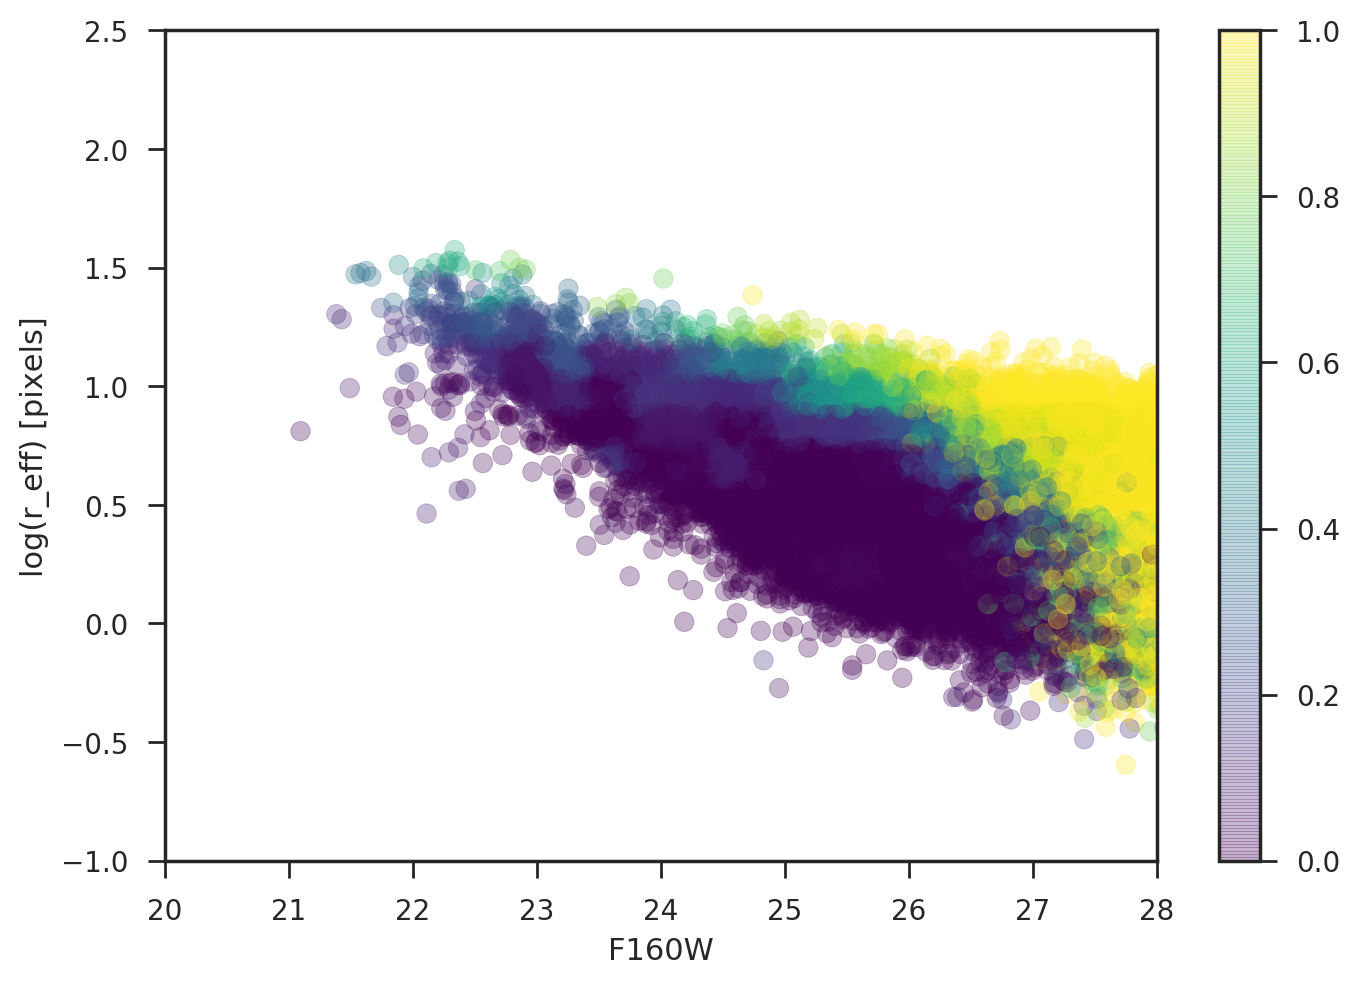

In [61]:
plt.scatter(df['wfc3f160w_dust_mag'][inzbin], np.log10(df['r_pixels'][inzbin]), 
    c=1.0-df['dp'][inzbin], alpha=0.3, cmap='viridis')
plt.colorbar()
plt.axis([20.0, 28.0, -1.0, 2.5])
plt.xlabel('F160W')
plt.ylabel('log(r_eff) [pixels]')

In [31]:
filename = '/project/projectdirs/cosmosim/slac/jderose/candels/mocks/sc/lightcone_goodss0_temp.h5'

In [32]:
write_candelized_quantities(df, filename, required_quantities)

['truth']


In [33]:
cf = h5py.File('/project/projectdirs/cosmosim/slac/jderose/candels/mocks/sc/lightcone_goodss0_temp.h5' ,'r')

In [34]:
list(cf['galaxyProperties'].keys())

['candelized', 'truth']

In [35]:
list(cf['galaxyProperties/candelized'].keys())

['BD_light',
 'BT_light',
 'BT_mass',
 'acsf435w_dust_flux',
 'acsf435w_dust_flux_noisy',
 'acsf435w_dust_fluxerr',
 'acsf435w_dust_mag',
 'acsf435w_dust_mag_noisy',
 'acsf435w_dust_magerr',
 'acsf435w_flux',
 'acsf435w_flux_noisy',
 'acsf435w_fluxerr',
 'acsf435w_mag',
 'acsf435w_mag_noisy',
 'acsf435w_magerr',
 'acsf606w_dust_flux',
 'acsf606w_dust_flux_noisy',
 'acsf606w_dust_fluxerr',
 'acsf606w_dust_mag',
 'acsf606w_dust_mag_noisy',
 'acsf606w_dust_magerr',
 'acsf606w_flux',
 'acsf606w_flux_noisy',
 'acsf606w_fluxerr',
 'acsf606w_mag',
 'acsf606w_mag_noisy',
 'acsf606w_magerr',
 'acsf775w_dust_flux',
 'acsf775w_dust_flux_noisy',
 'acsf775w_dust_fluxerr',
 'acsf775w_dust_mag',
 'acsf775w_dust_mag_noisy',
 'acsf775w_dust_magerr',
 'acsf775w_flux',
 'acsf775w_flux_noisy',
 'acsf775w_fluxerr',
 'acsf775w_mag',
 'acsf775w_mag_noisy',
 'acsf775w_magerr',
 'acsf814w_dust_flux',
 'acsf814w_dust_flux_noisy',
 'acsf814w_dust_fluxerr',
 'acsf814w_dust_mag',
 'acsf814w_dust_mag_noisy',
 'acsf

In [9]:
cf.close()

In [111]:
mock_noise_bands

['acsf435w',
 'acsf606w',
 'acsf775w',
 'acsf814w',
 'acsf850lp',
 'wfc3f275w',
 'wfc3f105w',
 'wfc3f125w',
 'wfc3f160w',
 'irac_ch1',
 'irac_ch2']

In [113]:
list(zip(mock_noise_bands, candels_noise_bands, candels_noise_bands))

[('acsf435w', 'acs_f435w', 'acs_f435w'),
 ('acsf606w', 'acs_f606w_v08', 'acs_f606w_v08'),
 ('acsf775w', 'acs_f775w', 'acs_f775w'),
 ('acsf814w', 'acs_f814w_v08', 'acs_f814w_v08'),
 ('acsf850lp', 'acs_f850lp', 'acs_f850lp'),
 ('wfc3f275w', 'wfc3_f275w', 'wfc3_f275w'),
 ('wfc3f105w', 'wfc3_f105w', 'wfc3_f105w'),
 ('wfc3f125w', 'wfc3_f125w_v08', 'wfc3_f125w_v08'),
 ('wfc3f160w', 'wfc3_f160w_v08', 'wfc3_f160w_v08'),
 ('irac_ch1', 'irac_ch1', 'irac_ch1'),
 ('irac_ch2', 'irac_ch2', 'irac_ch2')]